## Imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Tue Dec  9 01:36:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Condexión con Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Obtener dataset

In [4]:
!cp /content/drive/MyDrive/data.zip /content

In [5]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/data

### Analisis de datos

📌 Leyendo etiquetas de: train
📌 Leyendo etiquetas de: val
📌 Leyendo etiquetas de: test

📊 Cantidad de imágenes que contienen cada clase:
0 - semaforo_verde: 5138
1 - semaforo_rojo: 5540
2 - semaforo_amarillo: 364
3 - escaleras: 3021
4 - zebra: 2108
5 - podotactil: 635
6 - bache: 575


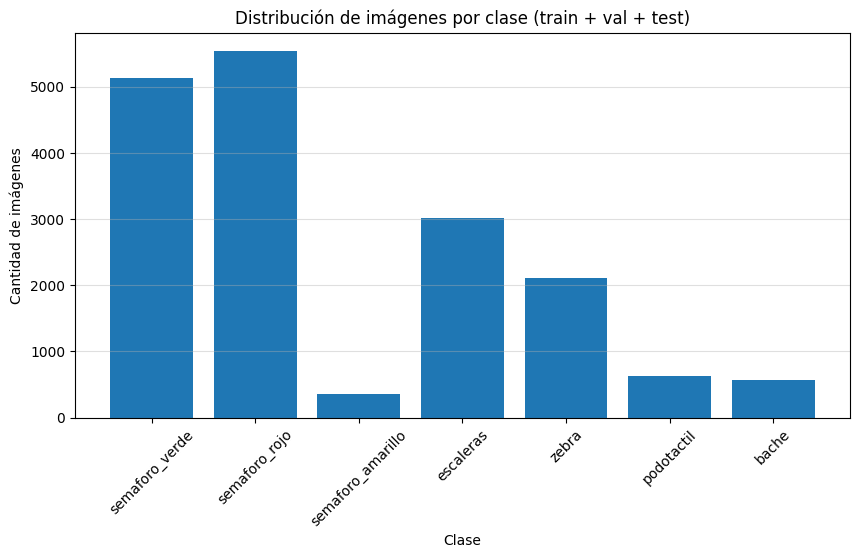

In [ ]:
import os
import matplotlib.pyplot as plt

# Ruta base de dataset
DATASET_ROOT = "/content/data"

# Nombres de clases
CLASS_NAMES = {
    0: "semaforo_verde",
    1: "semaforo_rojo",
    2: "semaforo_amarillo",
    3: "escaleras",
    4: "zebra",
    5: "podotactil",
    6: "bache"
}

# Diccionario para conteo total de imágenes
class_image_counts = {cls: 0 for cls in CLASS_NAMES.keys()}

# Procesar splits train / val / test
splits = ["train", "val", "test"]

for split in splits:
    labels_dir = os.path.join(DATASET_ROOT, split, "labels")

    if not os.path.exists(labels_dir):
        print(f"⚠ Carpeta no encontrada: {labels_dir}")
        continue

    print(f"📌 Leyendo etiquetas de: {split}")

    for label_file in os.listdir(labels_dir):
        if not label_file.endswith(".txt"):
            continue

        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()

        # Guardar las clases presentes en la imagen
        classes_in_image = set()
        for line in lines:
            cls = int(line.split()[0])
            classes_in_image.add(cls)
        for cls in classes_in_image:
            if cls in class_image_counts:
                class_image_counts[cls] += 1


# Mostrar conteo final
print("\n📊 Cantidad de imágenes que contienen cada clase:")
for cls, count in class_image_counts.items():
    print(f"{cls} - {CLASS_NAMES[cls]}: {count}")


# ----- Gráfica -----
classes = list(class_image_counts.keys())
names = [CLASS_NAMES[c] for c in classes]
counts = [class_image_counts[c] for c in classes]

plt.figure(figsize=(10, 5))
plt.bar(names, counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de imágenes por clase (train + val + test)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.4)
plt.show()


📌 Leyendo etiquetas de: train
📌 Leyendo etiquetas de: val
📌 Leyendo etiquetas de: test

📊 Conteo total por clase:
0 - semaforo_verde: 12004
1 - semaforo_rojo: 14983
2 - semaforo_amarillo: 851
3 - escaleras: 3166
4 - zebra: 2529
5 - podotactil: 770
6 - bache: 1224


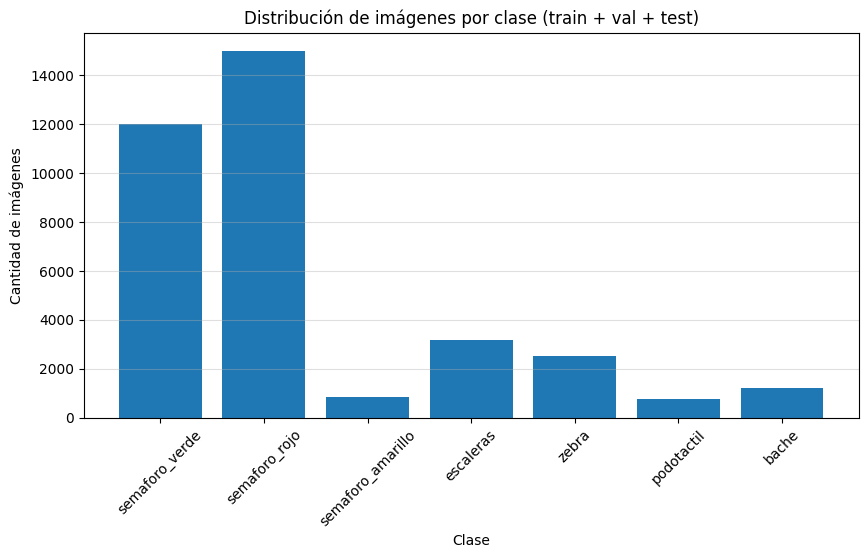

In [ ]:
import os
import matplotlib.pyplot as plt

# Ruta base de dataset
DATASET_ROOT = "/content/data"

# Nombres de clases
CLASS_NAMES = {
    0: "semaforo_verde",
    1: "semaforo_rojo",
    2: "semaforo_amarillo",
    3: "escaleras",
    4: "zebra",
    5: "podotactil",
    6: "bache"
}

# Diccionario para conteo total
class_counts = {cls: 0 for cls in CLASS_NAMES.keys()}

# Procesar splits train / val / test
splits = ["train", "val", "test"]

for split in splits:
    labels_dir = os.path.join(DATASET_ROOT, split, "labels")

    if not os.path.exists(labels_dir):
        print(f"⚠ Carpeta no encontrada: {labels_dir}")
        continue

    print(f"📌 Leyendo etiquetas de: {split}")

    for label_file in os.listdir(labels_dir):
        if not label_file.endswith(".txt"):
            continue

        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()

        for line in lines:
            cls = int(line.split()[0])
            if cls in class_counts:
                class_counts[cls] += 1


# Mostrar conteo final
print("\n📊 Conteo total por clase:")
for cls, count in class_counts.items():
    print(f"{cls} - {CLASS_NAMES[cls]}: {count}")


# ----- Gráfica -----
classes = list(class_counts.keys())
names = [CLASS_NAMES[c] for c in classes]
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(10, 5))
plt.bar(names, counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de imágenes por clase (train + val + test)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.4)
plt.show()


In [ ]:
!rm -rf /content/data/train_aug

## Data aumentation

In [6]:
import albumentations as A
import cv2
import os
import glob
from tqdm import tqdm

# --- CONFIGURACIÓN ---
input_folder = '/content/data/train'
output_folder = '/content/data/train_aug'

os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'labels'), exist_ok=True)

# --- DEFINICIÓN DE MULTIPLICADORES PARA BALANCEO ---
AUGMENTATION_MULTIPLIERS = {
    0: 0, # Verde - Sin agregar
    1: 0, # Rojo - Sin agregar
    2: 12, # Amarillo - Pocas -> aumentation x12
    3: 1, # Escaleras - Medio -> aumentation x1
    4: 2, # Zebra  - Medio -> aumentation x2)
    5: 7, # Podotactil - Pocas -> aumentation x7
    6: 8  # Bache - Pocas -> aumentation x8
}

# --- DATA AUMENTATION ---
transform = A.Compose([
    # Brillo suave
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.4
    ),

    # Niebla y Lluvia
    A.OneOf([
        # Niebla suave
        A.RandomFog(p=1),

        # Lluvia suave
        A.RandomRain(
            brightness_coefficient=0.9,
            drop_width=1,
            blur_value=2, # Blur bajo
            p=1
        ),
    ], p=0.15), # Probabilidad baja general

    # Desenfoque leve por movimiento
    A.MotionBlur(blur_limit=3, p=0.2),

    # Ruido
    A.GaussNoise(p=0.2),

    # Geometría
    A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))


def get_augmentation_count(class_ids):
    """Calcula cuántas copias crear según la clase más prioritaria."""
    if not class_ids:
        return 0

    max_multiplier = 0
    for cls in class_ids:
        mult = AUGMENTATION_MULTIPLIERS.get(cls, 0)
        if mult > max_multiplier:
            max_multiplier = mult

    return max_multiplier

def augment_dataset():
    # Buscar imágenes jpg y png
    image_paths = glob.glob(os.path.join(input_folder, 'images', '*.jpg'))
    image_paths += glob.glob(os.path.join(input_folder, 'images', '*.png'))

    print(f"Procesando {len(image_paths)} imágenes con balanceo adaptativo...")

    for img_path in tqdm(image_paths):
        try:
            filename = os.path.basename(img_path)
            name, ext = os.path.splitext(filename)
            label_path = os.path.join(input_folder, 'labels', name + '.txt')

            image = cv2.imread(img_path)
            if image is None: continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            bboxes = []
            class_labels = []

            # Leer etiquetas
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        parts = line.strip().split()
                        if len(parts) < 5: continue

                        # Leer como float
                        try:
                            cls = int(float(parts[0]))
                            coords = parts[1:5]
                            x, y, w, h = map(float, coords)
                            bboxes.append([x, y, w, h])
                            class_labels.append(cls)
                        except ValueError:
                            continue

            # 1. SIEMPRE GUARDAR LA ORIGINAL
            cv2.imwrite(os.path.join(output_folder, 'images', filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            if bboxes:
                with open(os.path.join(output_folder, 'labels', name + '.txt'), 'w') as f:
                    for bbox, cls in zip(bboxes, class_labels):
                        f.write(f"{cls} {' '.join(map(str, bbox))}\n")

            # 2. GENERAR COPIAS
            num_augments = get_augmentation_count(class_labels)

            if bboxes and num_augments > 0:
                for i in range(num_augments):
                    try:
                        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                        aug_img = augmented['image']
                        aug_bboxes = augmented['bboxes']
                        aug_labels = augmented['class_labels']

                        # Guardar imagen aumentada
                        aug_filename = f"{name}_aug_{i}{ext}"
                        cv2.imwrite(os.path.join(output_folder, 'images', aug_filename), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

                        # Guardar label aumentado
                        with open(os.path.join(output_folder, 'labels', f"{name}_aug_{i}.txt"), 'w') as f:
                            for bbox, cls in zip(aug_bboxes, aug_labels):
                                bbox = [min(max(val, 0.0), 1.0) for val in bbox]
                                f.write(f"{cls} {' '.join(map(str, bbox))}\n")
                    except Exception:
                        pass # Ignorar errores puntuales de transformación

        except Exception as e:
            print(f"Error en archivo {filename}: {e}")

# Ejecutar
augment_dataset()
print("¡Dataset balanceado y generado con éxito!")

Procesando 11793 imágenes con balanceo adaptativo...


100%|██████████| 11793/11793 [04:41<00:00, 41.84it/s]

¡Dataset balanceado y generado con éxito!


### Data analisis

📌 Leyendo etiquetas de: train_aug

📊 Conteo total por clase en el Dataset Aumentado:
0 - semaforo_verde: 10374
1 - semaforo_rojo: 14534
2 - semaforo_amarillo: 8294
3 - escaleras: 5100
4 - zebra: 5459
5 - podotactil: 4352
6 - bache: 7605


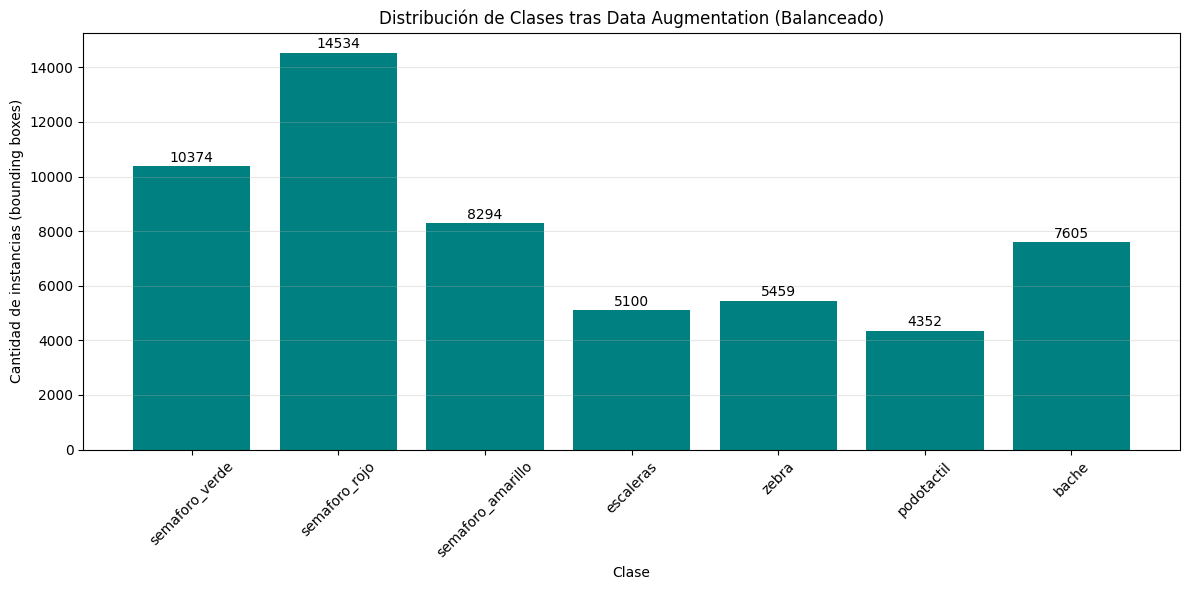

In [ ]:
import os
import matplotlib.pyplot as plt

# Ruta base de dataset
DATASET_ROOT = "/content/data"

# Nombres de clases
CLASS_NAMES = {
    0: "semaforo_verde",
    1: "semaforo_rojo",
    2: "semaforo_amarillo",
    3: "escaleras",
    4: "zebra",
    5: "podotactil",
    6: "bache"
}

# Diccionario para conteo total
class_counts = {cls: 0 for cls in CLASS_NAMES.keys()}

# Procesar solo el split aumentado
splits = ["train_aug"]

for split in splits:
    labels_dir = os.path.join(DATASET_ROOT, split, "labels")

    if not os.path.exists(labels_dir):
        print(f"⚠ Carpeta no encontrada: {labels_dir}")
        continue

    print(f"📌 Leyendo etiquetas de: {split}")

    # Listar archivos
    files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

    for label_file in files:
        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()

            # Verificación de seguridad (líneas vacías)
            if len(parts) > 0:
                try:
                    # --- CORRECCIÓN AQUÍ ---
                    # Leemos como float ('5.0') y convertimos a int (5)
                    cls = int(float(parts[0]))

                    if cls in class_counts:
                        class_counts[cls] += 1
                except ValueError:
                    pass # Ignorar líneas corruptas si las hubiera

# Mostrar conteo final numérico
print("\n📊 Conteo total por clase en el Dataset Aumentado:")
for cls, count in class_counts.items():
    name = CLASS_NAMES.get(cls, "Desconocido")
    print(f"{cls} - {name}: {count}")

# ----- Gráfica -----
classes = list(class_counts.keys())
names = [CLASS_NAMES[c] for c in classes]
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(12, 6))

# Usamos un color distinto para resaltar que es el dataset "mejorado"
bars = plt.bar(names, counts, color='teal')

plt.xlabel("Clase")
plt.ylabel("Cantidad de instancias (bounding boxes)")
plt.title("Distribución de Clases tras Data Augmentation (Balanceado)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir los números encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Ejemplo

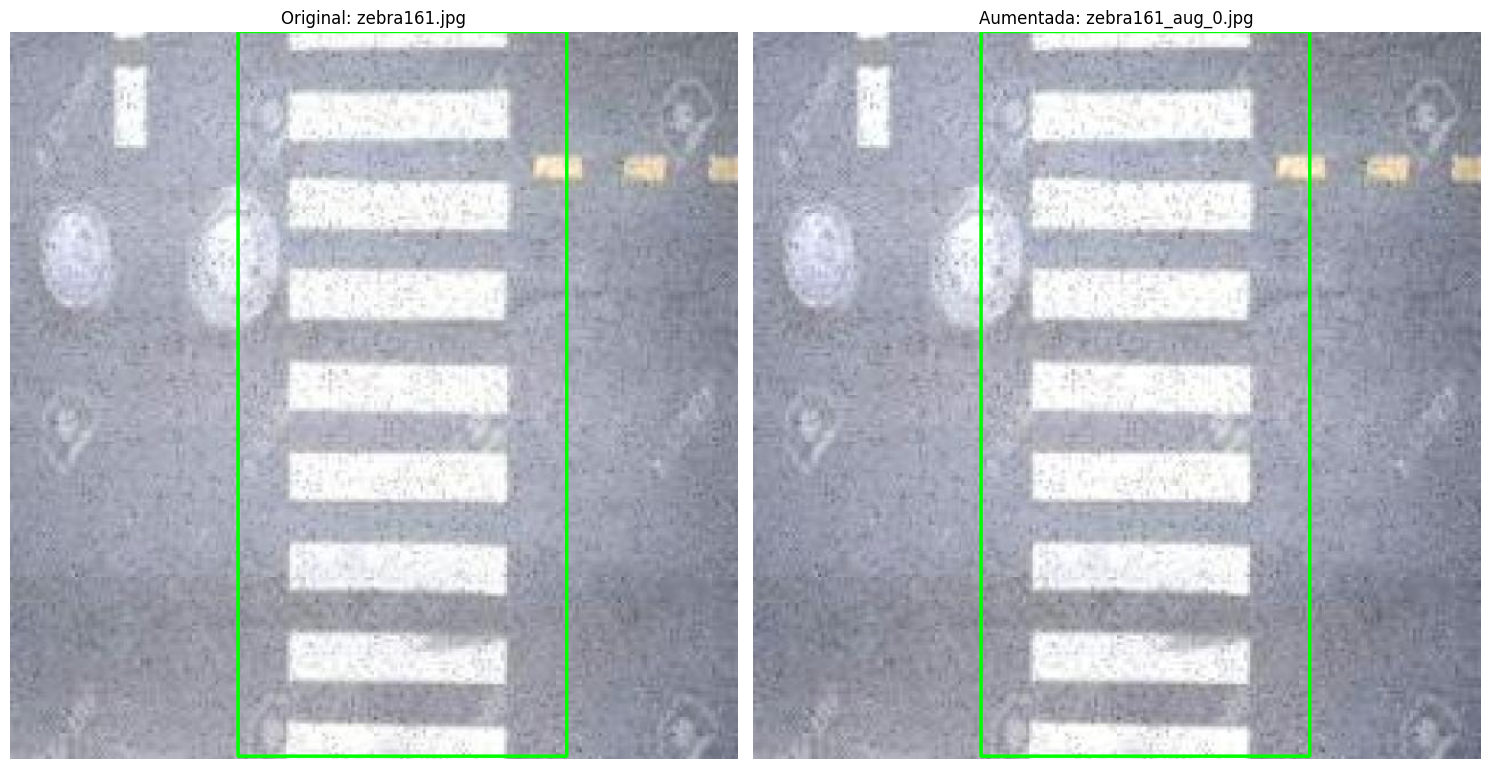

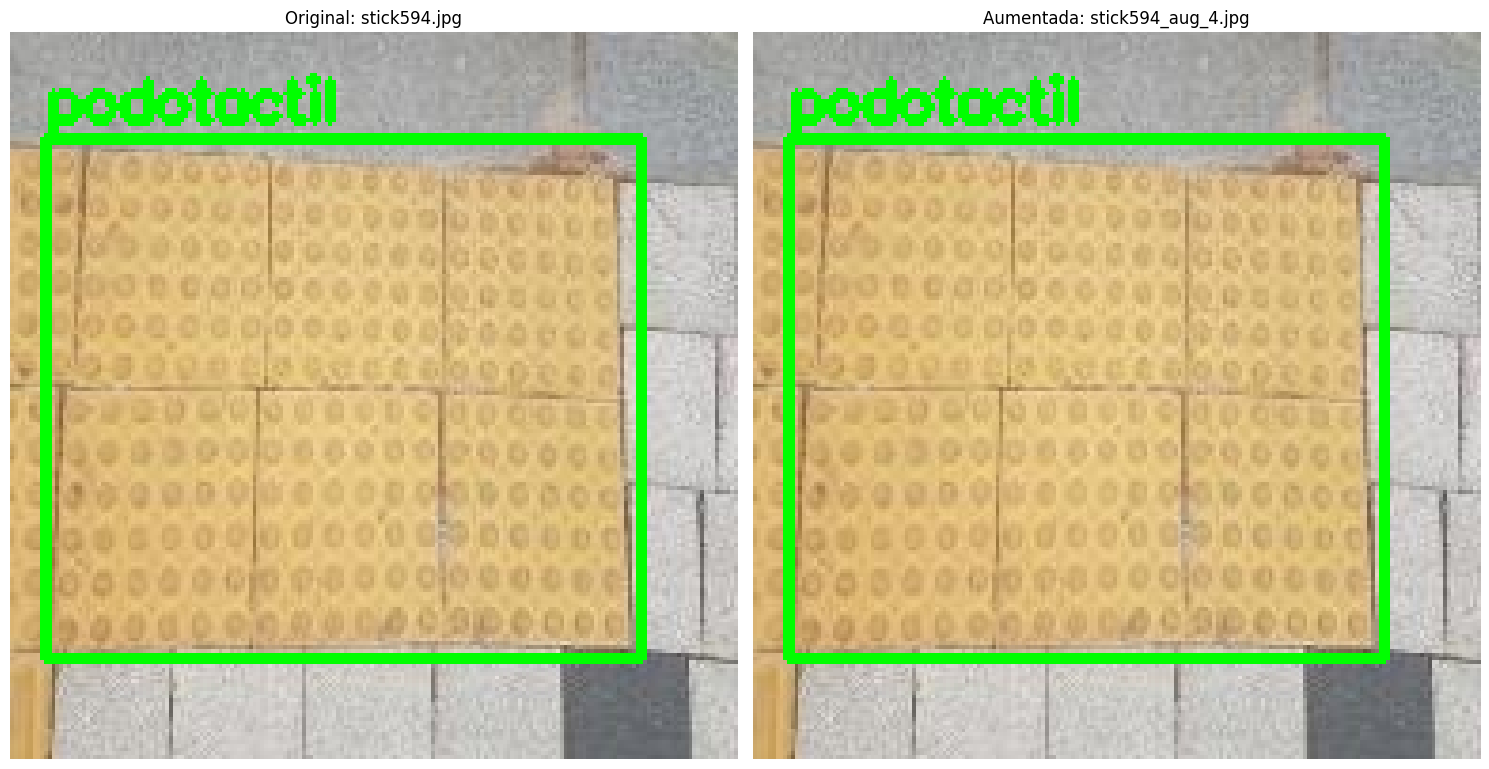

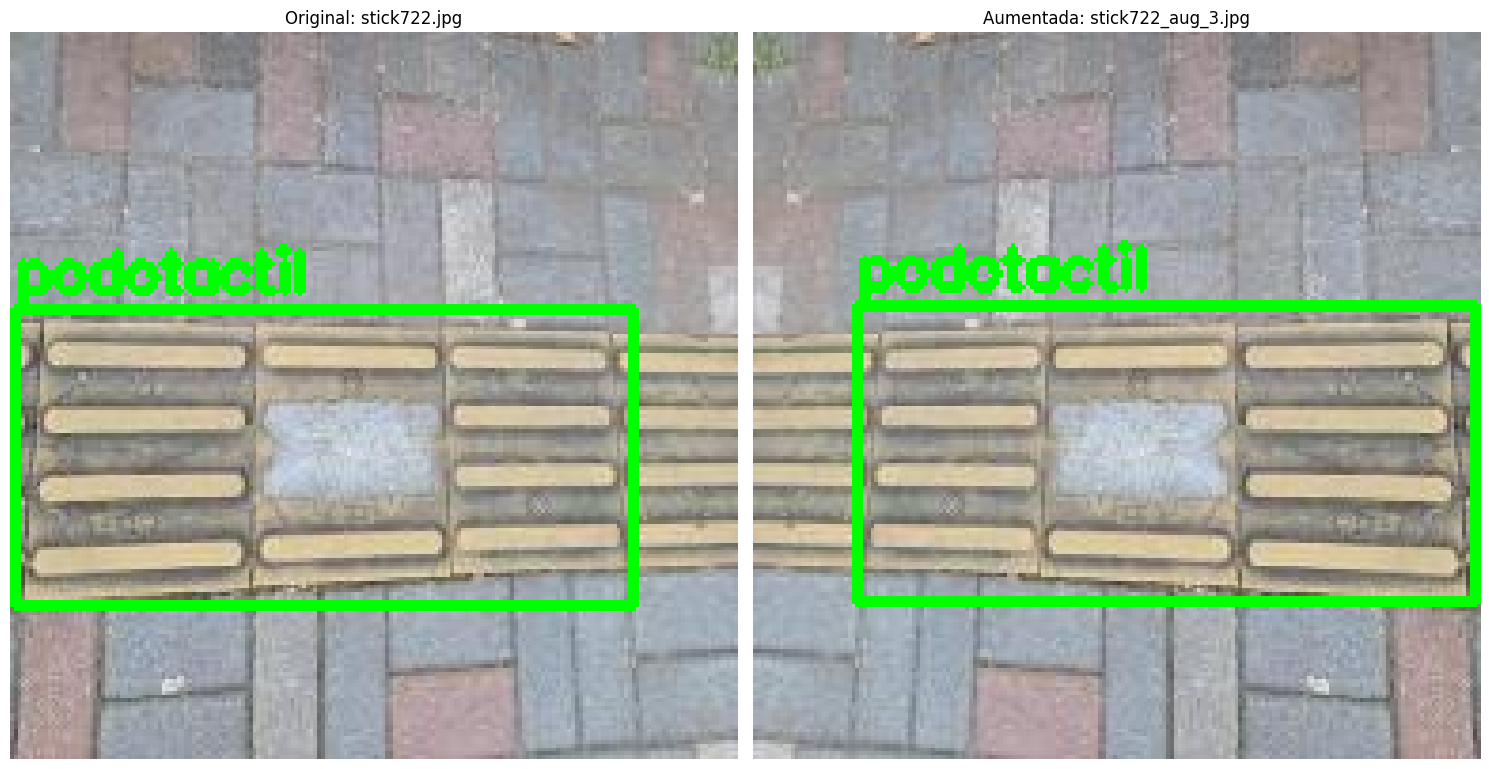

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import glob

# --- CONFIGURACIÓN ---
data_path = '/content/data/train_aug'

# Nombres de clases
class_names = ['Semaforo Verde', 'Semaforo Rojo', 'Semaforo Amarillo',
               'Escalera', 'Paso Zebra', "podotactil", 'Bache']

def draw_yolo_boxes(img, label_path, class_list):
    img_h, img_w, _ = img.shape
    img_copy = img.copy()

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 5: continue

                try:
                    cls_idx = int(float(parts[0]))
                    x_center, y_center, w, h = map(float, parts[1:5])

                    x_min = int((x_center - w/2) * img_w)
                    y_min = int((y_center - h/2) * img_h)
                    x_max = int((x_center + w/2) * img_w)
                    y_max = int((y_center + h/2) * img_h)

                    color = (0, 255, 0)
                    thickness = 2

                    cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, thickness)

                    label_text = class_list[cls_idx] if cls_idx < len(class_list) else str(cls_idx)
                    cv2.putText(img_copy, label_text, (x_min, y_min - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                except:
                    continue
    return img_copy


# --- LÓGICA DE VISUALIZACIÓN ---
aug_images = glob.glob(os.path.join(data_path, 'images', '*_aug_*.jpg')) + \
             glob.glob(os.path.join(data_path, 'images', '*_aug_*.png'))

if len(aug_images) == 0:
    print("No se encontraron imágenes aumentadas.")
else:
    # Seleccionar 3 imágenes sin repetir
    sample_images = random.sample(aug_images, min(3, len(aug_images)))

    for aug_img_path in sample_images:
        filename = os.path.basename(aug_img_path)

        try:
            # Obtener versión original
            name_base = filename.split('_aug_')[0]
            ext = os.path.splitext(filename)[1]
            orig_filename = name_base + ext

            orig_img_path = os.path.join(data_path, 'images', orig_filename)

            # Rutas labels
            name_aug = os.path.splitext(filename)[0]
            name_orig = os.path.splitext(orig_filename)[0]

            aug_label_path = os.path.join(data_path, 'labels', name_aug + '.txt')
            orig_label_path = os.path.join(data_path, 'labels', name_orig + '.txt')

            # Cargar imágenes
            img_aug = cv2.imread(aug_img_path)
            img_orig = cv2.imread(orig_img_path)

            if img_aug is None or img_orig is None:
                print(f"No se pudo cargar: {filename}")
                continue

            img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

            # Dibujar cajas
            img_orig_boxes = draw_yolo_boxes(img_orig, orig_label_path, class_names)
            img_aug_boxes = draw_yolo_boxes(img_aug, aug_label_path, class_names)

            # Mostrar 1 par
            plt.figure(figsize=(15, 8))

            plt.subplot(1, 2, 1)
            plt.title(f"Original: {orig_filename}")
            plt.imshow(img_orig_boxes)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Aumentada: {filename}")
            plt.imshow(img_aug_boxes)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error procesando {filename}: {e}")


## Entrenamiento

### Creación del yaml

In [8]:
import yaml
import os

def create_data_yaml(path_to_data_yaml):
    # 1. Definimos las clases EXACTAMENTE en el orden de tus índices (0 al 6)
    # Nota: Usamos un diccionario para asegurar que el índice coincida con el nombre
    classes = {
        0: 'semanforo-verde',
        1: 'semanforo-amarillo',
        2: 'semanforo-rojo',
        3: 'escaleras',
        4: 'zebra',
        5: 'podotactil',
        6: 'bache'
    }

    # 2. Creamos el diccionario de configuración
    # IMPORTANTE: 'train' apunta a 'train_aug/images', la carpeta que acabamos de crear/aumentar
    data = {
        'path': '/content/data',       # Directorio raíz
        'train': 'train_aug/images',   # <--- AQUÍ ESTÁ LA CLAVE (Usamos la data aumentada)
        'val': 'val/images',           # Carpeta de validación (original)
        'test': 'test/images',         # Carpeta de test (original)

        # Información de clases
        'nc': len(classes),            # Número de clases (7)
        'names': classes               # Nombres mapeados
    }

    # 3. Escribir el archivo YAML
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f'✅ Archivo de configuración creado exitosamente en: {path_to_data_yaml}')
    return

# Definir ruta y ejecutar
path_to_data_yaml = '/content/data/data.yaml'

create_data_yaml(path_to_data_yaml)

print('\n📄 Contenido del archivo data.yaml generado:\n')
!cat /content/data/data.yaml

✅ Archivo de configuración creado exitosamente en: /content/data/data.yaml

📄 Contenido del archivo data.yaml generado:

path: /content/data
train: train_aug/images
val: val/images
test: test/images
nc: 7
names:
  0: semanforo-verde
  1: semanforo-amarillo
  2: semanforo-rojo
  3: escaleras
  4: zebra
  5: podotactil
  6: bache


### Entrenamiento

### MODELO 1
IMG size 640

In [ ]:
!yolo task=detect mode=train \
    model=yolo11n.pt \
    data=/content/data/data.yaml \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    patience=10 \
    device=0 \
    name=modelo_alta_precision \
    project=runs/detect \
    exist_ok=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kob

### Guardar el modelo

In [ ]:
import os
import shutil
from datetime import datetime

# --- CONFIGURACIÓN ---
# Buscamos exactamente la carpeta del Modelo A
model_name = "modelo_alta_precision"
runs_path = "/content/runs/detect"
source_path = os.path.join(runs_path, model_name)

# --- VERIFICAR SI EXISTE ---
if not os.path.exists(source_path):
    print(f"❌ Error: No se encontró la carpeta '{model_name}' en {runs_path}")
    print("Asegúrate de haber ejecutado el entrenamiento del Modelo A primero.")
else:
    print(f"✔ Modelo A encontrado en: {source_path}")

    # --- CREAR CARPETA EN GOOGLE DRIVE ---
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # Le ponemos un nombre claro en Drive para no confundirlo
    drive_output = f"/content/drive/MyDrive/yolo_results/MODELO_A_PRECISION_{timestamp}"
    os.makedirs(drive_output, exist_ok=True)

    # --- COPIAR RESULTADOS ---
    print(f"⏳ Copiando archivos a Google Drive...")
    shutil.copytree(source_path, drive_output, dirs_exist_ok=True)

    print(f"✅ ¡Guardado exitoso! Tus archivos están en: {drive_output}")

✔ Modelo A encontrado en: /content/runs/detect/modelo_alta_precision
⏳ Copiando archivos a Google Drive...
✅ ¡Guardado exitoso! Tus archivos están en: /content/drive/MyDrive/yolo_results/MODELO_A_PRECISION_2025-12-08_22-09-43


### TEST

✅ Cargando modelo desde: /content/runs/detect/modelo_alta_precision/weights/best.pt

🔍 Ejecutando inferencia en 4 imágenes del Test Set...

[semaforo6870.jpg] -> Inferencia: 8.0ms
[stick2402.jpg] -> Inferencia: 7.9ms
[escaleras1614.jpg] -> Inferencia: 7.9ms
[semaforo7315.jpg] -> Inferencia: 8.0ms


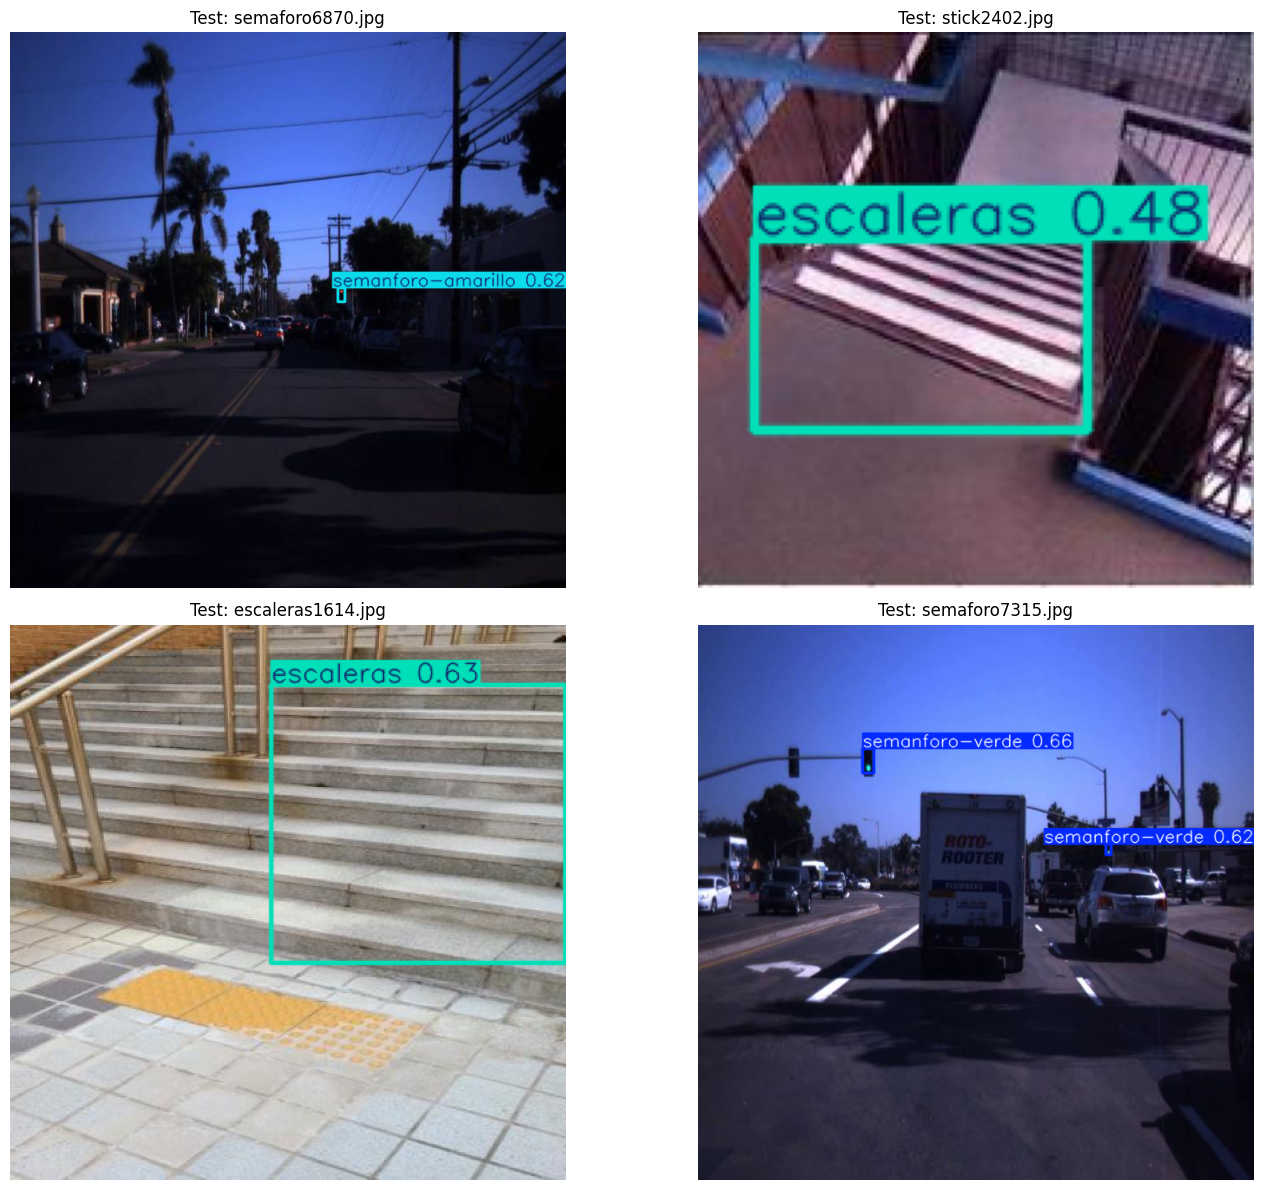

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import glob
import random
import os
import cv2

# --- CONFIGURACIÓN ---
# 1. Ruta de tu modelo entrenado (Asegúrate que sea 'best.pt')
# Si usaste el nombre que te di antes, debería estar aquí:
model_path = '/content/runs/detect/modelo_alta_precision/weights/best.pt'

# 2. Ruta de las imágenes de prueba (Test)
test_images_path = '/content/data/test/images'

# 3. ¿Cuántas imágenes quieres ver?
num_samples = 4

# --- CARGAR MODELO Y EJECUTAR ---
if not os.path.exists(model_path):
    print(f"❌ No se encontró el modelo en: {model_path}")
    print("Verifica la ruta o si el entrenamiento terminó correctamente.")
else:
    print(f"✅ Cargando modelo desde: {model_path}")
    model = YOLO(model_path)

    # Buscar imágenes de test
    test_files = glob.glob(os.path.join(test_images_path, '*.jpg')) + \
                 glob.glob(os.path.join(test_images_path, '*.png'))

    if not test_files:
        print("❌ No se encontraron imágenes en la carpeta de test.")
    else:
        # Seleccionar aleatorias
        selected_files = random.sample(test_files, min(len(test_files), num_samples))

        plt.figure(figsize=(15, 12))

        print(f"\n🔍 Ejecutando inferencia en {len(selected_files)} imágenes del Test Set...\n")

        for i, file_path in enumerate(selected_files):
            # EJECUTAR INFERENCIA
            # conf=0.25: Umbral de confianza (puedes subirlo si quieres ver solo lo muy seguro)
            results = model.predict(file_path, conf=0.25, verbose=False)

            # OBTENER IMAGEN CON CAJAS DIBUJADAS
            # result.plot() devuelve la imagen en formato BGR (OpenCV standard)
            result_img_bgr = results[0].plot()

            # Convertir a RGB para que Matplotlib la muestre con colores correctos
            result_img_rgb = cv2.cvtColor(result_img_bgr, cv2.COLOR_BGR2RGB)

            # MOSTRAR
            plt.subplot(2, 2, i + 1) # Ajusta esto si cambias num_samples
            plt.imshow(result_img_rgb)
            plt.title(f"Test: {os.path.basename(file_path)}")
            plt.axis('off')

            # Imprimir velocidad (Info valiosa para tu reporte de RPi)
            speed = results[0].speed
            print(f"[{os.path.basename(file_path)}] -> Inferencia: {speed['inference']:.1f}ms")

        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd
import os

# Ruta al archivo de resultados (ajusta si cambiaste el nombre del proyecto)
# Usualmente es: runs/detect/modelo_alta_precision/results.csv
results_path = '/content/runs/detect/modelo_alta_precision/results.csv'

if os.path.exists(results_path):
    # Leer CSV (YOLO a veces pone espacios en los nombres de columnas)
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip() # Quitar espacios extra

    # Obtener la mejor época (mayor mAP50-95)
    best_epoch = df.loc[df['metrics/mAP50-95(B)'].idxmax()]

    print(f"El modelo alcanzó su mejor rendimiento en la época {int(best_epoch['epoch'])}.")
    print("\n| Métrica | Valor |")
    print("| :--- | :--- |")
    print(f"| Precision | {best_epoch['metrics/precision(B)']:.3f} |")
    print(f"| Recall | {best_epoch['metrics/recall(B)']:.3f} |")
    print(f"| mAP@50 | {best_epoch['metrics/mAP50(B)']:.3f} |")
    print(f"| mAP@50-95 | {best_epoch['metrics/mAP50-95(B)']:.3f} |")

else:
    print("Aún no se encuentra el archivo results.csv. Espera a que termine el entrenamiento.")

El modelo alcanzó su mejor rendimiento en la época 50.

| Métrica | Valor |
| :--- | :--- |
| Precision | 0.870 |
| Recall | 0.848 |
| mAP@50 | 0.883 |
| mAP@50-95 | 0.579 |


### MODELO 2
IMG size 320



In [9]:
!yolo task=detect mode=train \
    model=yolo11n.pt \
    data=/content/data/data.yaml \
    epochs=50 \
    imgsz=320 \
    batch=32 \
    patience=10 \
    device=0 \
    name=modelo_rapido_rpi \
    project=runs/detect \
    exist_ok=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kob

### Guardar el modelo

In [10]:
import os
import shutil
from datetime import datetime
from google.colab import drive

# 1. Asegurar que Drive esté conectado
if not os.path.exists('/content/drive'):
    print("🔌 Conectando a Google Drive...")
    drive.mount('/content/drive')

# --- CONFIGURACIÓN PARA MODELO B ---
# Buscamos la carpeta definida en el comando de arriba (name=modelo_rapido_rpi)
model_name = "modelo_rapido_rpi"
runs_path = "/content/runs/detect"
source_path = os.path.join(runs_path, model_name)

# --- VERIFICAR SI EXISTE ---
if not os.path.exists(source_path):
    print(f"❌ Error: No se encontró la carpeta '{model_name}' en {runs_path}")
    print("Asegúrate de que el entrenamiento del Modelo B terminó correctamente.")
else:
    print(f"✔ Modelo B (Rápido) encontrado en: {source_path}")

    # --- CREAR CARPETA EN GOOGLE DRIVE ---
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Nombre distintivo para diferenciarlo del Modelo A
    drive_output = f"/content/drive/MyDrive/yolo_results/MODELO_B_RAPIDO_{timestamp}"

    os.makedirs(drive_output, exist_ok=True)

    # --- COPIAR RESULTADOS ---
    print(f"⏳ Copiando archivos a Google Drive...")
    shutil.copytree(source_path, drive_output, dirs_exist_ok=True)

    print(f"✅ ¡Guardado exitoso! Tus archivos están en: {drive_output}")

✔ Modelo B (Rápido) encontrado en: /content/runs/detect/modelo_rapido_rpi
⏳ Copiando archivos a Google Drive...
✅ ¡Guardado exitoso! Tus archivos están en: /content/drive/MyDrive/yolo_results/MODELO_B_RAPIDO_2025-12-09_04-36-37


### TEST

✅ Cargando Modelo B (Rápido) desde: /content/runs/detect/modelo_rapido_rpi/weights/best.pt

🔍 Ejecutando inferencia (Modelo B - 320px) en 4 imágenes...

[semaforo7538.jpg]
   ⏱️ Inferencia: 7.6ms (Total: 9.8ms)
[semaforo6917.jpg]
   ⏱️ Inferencia: 7.9ms (Total: 9.7ms)
[semaforo7622.jpg]
   ⏱️ Inferencia: 7.6ms (Total: 10.3ms)
[semaforo7256.jpg]
   ⏱️ Inferencia: 7.8ms (Total: 9.5ms)


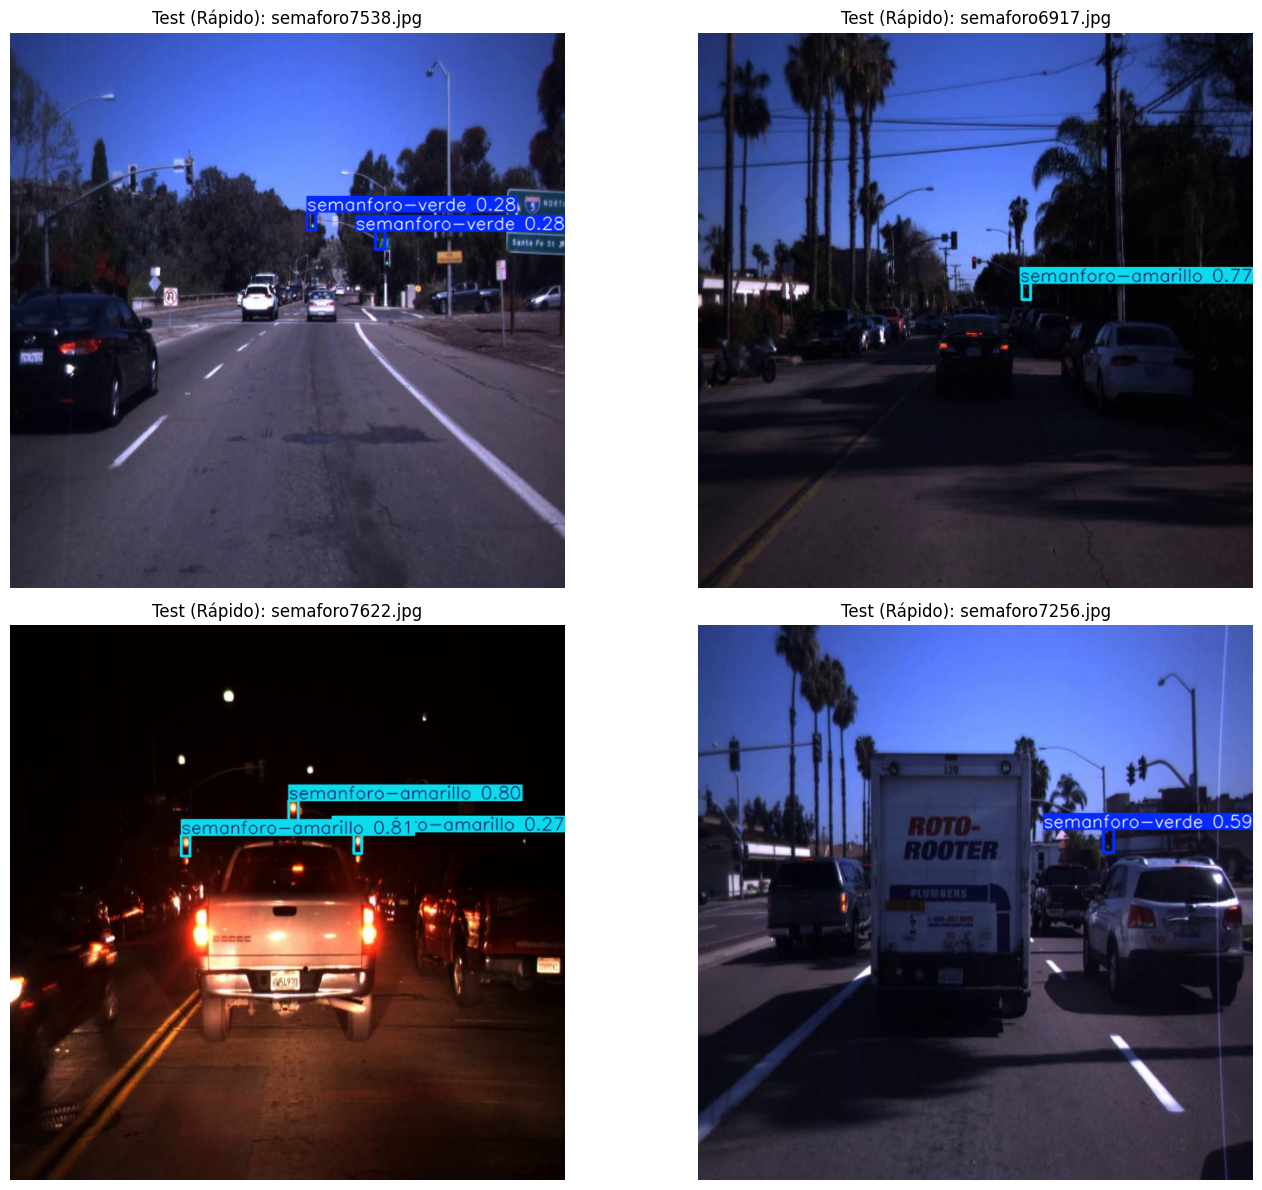

In [19]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import glob
import random
import os
import cv2

# --- CONFIGURACIÓN PARA MODELO B (RÁPIDO) ---
# 1. Ruta de tu modelo optimizado para RPi
# Nota el cambio en la carpeta: 'modelo_rapido_rpi'
model_path = '/content/runs/detect/modelo_rapido_rpi/weights/best.pt'

# 2. Ruta de las imágenes de prueba (Test)
test_images_path = '/content/data/test/images'

# 3. ¿Cuántas imágenes quieres ver?
num_samples = 4

# --- CARGAR MODELO Y EJECUTAR ---
if not os.path.exists(model_path):
    print(f"❌ No se encontró el modelo en: {model_path}")
    print("Asegúrate de que el entrenamiento del 'modelo_rapido_rpi' terminó correctamente.")
else:
    print(f"✅ Cargando Modelo B (Rápido) desde: {model_path}")
    model = YOLO(model_path)

    # Buscar imágenes de test
    test_files = glob.glob(os.path.join(test_images_path, '*.jpg')) + \
                 glob.glob(os.path.join(test_images_path, '*.png'))

    if not test_files:
        print("❌ No se encontraron imágenes en la carpeta de test.")
    else:
        # Seleccionar aleatorias
        selected_files = random.sample(test_files, min(len(test_files), num_samples))

        plt.figure(figsize=(15, 12))

        print(f"\n🔍 Ejecutando inferencia (Modelo B - 320px) en {len(selected_files)} imágenes...\n")

        for i, file_path in enumerate(selected_files):
            # EJECUTAR INFERENCIA
            # No es necesario especificar imgsz=320 aquí, el modelo ya sabe su tamaño nativo
            results = model.predict(file_path, conf=0.25, verbose=False)

            # OBTENER IMAGEN CON CAJAS
            result_img_bgr = results[0].plot()
            result_img_rgb = cv2.cvtColor(result_img_bgr, cv2.COLOR_BGR2RGB)

            # MOSTRAR
            plt.subplot(2, 2, i + 1)
            plt.imshow(result_img_rgb)
            plt.title(f"Test (Rápido): {os.path.basename(file_path)}")
            plt.axis('off')

            # DATOS DE VELOCIDAD
            speed = results[0].speed
            preprocess = speed['preprocess']
            inference = speed['inference']
            postprocess = speed['postprocess']
            total_time = preprocess + inference + postprocess

            print(f"[{os.path.basename(file_path)}]")
            print(f"   ⏱️ Inferencia: {inference:.1f}ms (Total: {total_time:.1f}ms)")

        plt.tight_layout()
        plt.show()

In [12]:
import pandas as pd
import os

# --- CONFIGURACIÓN ---
# Cambiamos la ruta a la carpeta del Modelo B
results_path = '/content/runs/detect/modelo_rapido_rpi/results.csv'
model_name = "Modelo B (Optimizado RPi - 320px)"

if os.path.exists(results_path):
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

    # Obtener la mejor época basada en mAP50-95
    best_epoch_idx = df['metrics/mAP50-95(B)'].idxmax()
    best_epoch = df.loc[best_epoch_idx]

    print(f"📊 ANÁLISIS FINAL: {model_name}")
    print(f"Mejor rendimiento alcanzado en la época {int(best_epoch['epoch'])}.")

    print("\n| Métrica | Valor |")
    print("| :--- | :--- |")
    print(f"| Precision | {best_epoch['metrics/precision(B)']:.3f} |")
    print(f"| Recall | {best_epoch['metrics/recall(B)']:.3f} |")
    print(f"| mAP@50 | {best_epoch['metrics/mAP50(B)']:.3f} |")
    print(f"| mAP@50-95 | {best_epoch['metrics/mAP50-95(B)']:.3f} |")

    # Intentar obtener métricas de pérdida final para ver convergencia
    print(f"| Box Loss | {best_epoch['val/box_loss']:.4f} |")
    print(f"| Cls Loss | {best_epoch['val/cls_loss']:.4f} |")

else:
    print(f"❌ No se encuentra el archivo en: {results_path}")
    print("Verifica que el entrenamiento del Modelo B haya terminado.")

📊 ANÁLISIS FINAL: Modelo B (Optimizado RPi - 320px)
Mejor rendimiento alcanzado en la época 50.

| Métrica | Valor |
| :--- | :--- |
| Precision | 0.832 |
| Recall | 0.745 |
| mAP@50 | 0.797 |
| mAP@50-95 | 0.494 |
| Box Loss | 1.4294 |
| Cls Loss | 0.7700 |


## Analisis de Resultados

### Comparación

In [24]:
import pandas as pd
import os

# Rutas de tus dos experimentos
path_a = '/content/runs/detect/modelo_alta_precision/results.csv'
path_b = '/content/runs/detect/modelo_rapido_rpi/results.csv'

def get_best_metrics(path):
    if not os.path.exists(path): return None
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    # Retornamos la fila con mejor mAP50-95
    return df.loc[df['metrics/mAP50-95(B)'].idxmax()]

metrics_a = get_best_metrics(path_a)
metrics_b = get_best_metrics(path_b)

if metrics_a is not None and metrics_b is not None:
    print("| Métrica | Modelo A (Precisión/640px) | Modelo B (Rápido/320px) | Diferencia |")
    print("| :--- | :--- | :--- | :--- |")

    # Lista de métricas a comparar
    comparisons = [
        ('mAP@50-95', 'metrics/mAP50-95(B)'),
        ('mAP@50', 'metrics/mAP50(B)'),
        ('Precision', 'metrics/precision(B)'),
        ('Recall', 'metrics/recall(B)')
    ]

    for label, key in comparisons:
        val_a = metrics_a[key]
        val_b = metrics_b[key]
        diff = val_b - val_a # Cuánto ganamos/perdimos con el B

        # Formato bonito con signo + o -
        diff_str = f"{diff:+.3f}"

        print(f"| {label} | {val_a:.3f} | {val_b:.3f} | {diff_str} |")
else:
    print("❌ Faltan archivos. Asegúrate de haber entrenado ambos modelos.")

| Métrica | Modelo A (Precisión/640px) | Modelo B (Rápido/320px) | Diferencia |
| :--- | :--- | :--- | :--- |
| mAP@50-95 | 0.579 | 0.494 | -0.085 |
| mAP@50 | 0.883 | 0.797 | -0.086 |
| Precision | 0.870 | 0.832 | -0.038 |
| Recall | 0.848 | 0.745 | -0.103 |
